In [1]:
import modules.model_mobilenetv2 as my_model
import modules.model_mobilenetv2_1M as my_model_1M

import modules.model_mobilenetv2_small as my_model_small
import modules.model_mobilenetv2_mini as my_model_mini

import numpy as np
import torch
from torchinfo import summary

import matplotlib.pyplot as plt

# Profiler: torchprofile

In [2]:
from torchprofile import profile_macs

# Profiler: torchlop

In [3]:
from torchlop import profile

In [4]:
def get_macs_and_params_per_layer(model):

    dummy_inp = torch.randn(1, 3, 224, 224)
    macs, params, layer_infos = profile(model, inputs=(dummy_inp, ))

    print('Total MACs of {}: {:.4g} M'.format(model.__class__.__name__, macs / 1e6))
    print('Total params of {}: {}'.format(model.__class__.__name__, params))

    macs_layer = {}
    params_layer = {}

    conv_idx = 0
    linear_idx = 0
    
    for i, k in enumerate(layer_infos.keys()):
        layer_type = layer_infos[k]["type"]
        layer_ops = layer_infos[k]["ops"]
        layer_params = layer_infos[k]["params"]
        if layer_ops != 0 and layer_type != "BatchNorm2d":
            if layer_type == "Conv2d": 
                macs_layer.update({layer_type + '_' + str(conv_idx): layer_ops})   
                params_layer.update({layer_type + '_' + str(conv_idx): layer_params}) 
                conv_idx += 1
            elif layer_type == "Linear":
                macs_layer.update({layer_type + '_' + str(linear_idx): layer_ops}) 
                params_layer.update({layer_type + '_' + str(linear_idx): layer_params})  
                linear_idx += 1 
            else:
                macs_layer.update({layer_type: layer_ops})
                params_layer.update({layer_type: layer_params})

    return macs_layer, params_layer

## Plot results

In [5]:
def plot_results(res_layer, res_type: str):
    fig, ax = plt.subplots(figsize=(10,3))

    layers_name = list(res_layer.keys())
    layer_res = list(res_layer.values())
    
    rects = ax.bar(layers_name, layer_res)
    ax.bar_label(rects, padding=3, fontsize=7)
    if res_type == "macs":
        ylabel = "MACs (M)"
        title = "MACs per layer (M)"
    elif res_type == "params":
        ylabel = "#Params"  
        title = "#Params per layer"
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)
    
    plt.show()

# Models

In [6]:
model = my_model.MobileNetV2().to('cpu')
model_1M = my_model_1M.MobileNetV2_1M(width_mult=1.).to('cpu')

model_small = my_model_small.MobileNetV2_SMALL().to('cpu')
model_mini = my_model_mini.MobileNetV2_MINI().to('cpu')

In [7]:
model.eval();
model_1M.eval();
model_small.eval();
model_mini.eval();

## MobileNetV2

### Profile

In [8]:
inputs = torch.randn(1, 3, 224, 224)

macs = profile_macs(model, inputs)
print('{}: {:.4g} M'.format(model.__class__.__name__, macs / 1e6))

MobileNetV2: 245.9 M


In [9]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model)

Total MACs of MobileNetV2: 251.8 M
Total params of MobileNetV2: 1719042.0


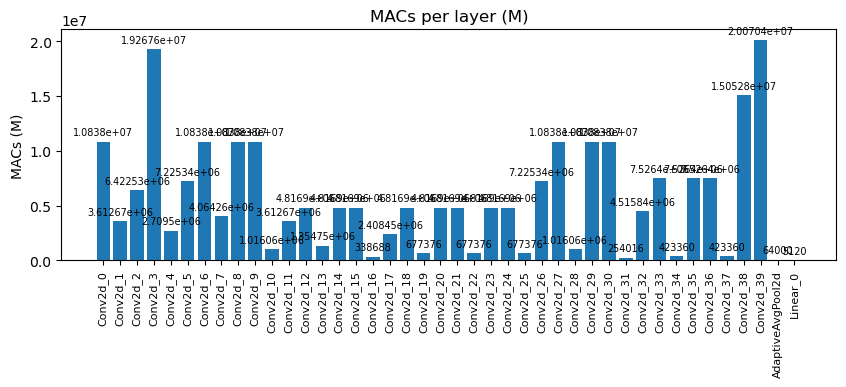

In [10]:
plot_results(macs_mbnet, res_type="macs")

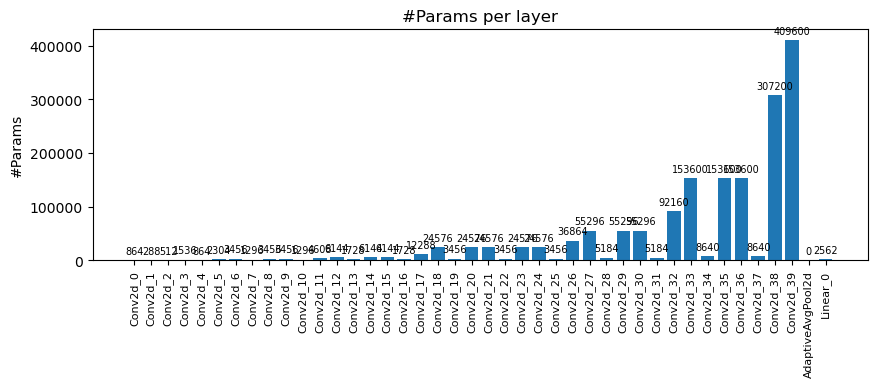

In [11]:
plot_results(params_mbnet, res_type="params")

### Summary

In [12]:
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2                              [1, 2]                    --
├─Sequential: 1-1                        [1, 320, 7, 7]            --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4              [1, 16, 112, 112]         896
│    └─InvertedBlock: 2-3                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 24, 56, 56]           5,136
│    └─InvertedBlock: 2-4                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 24, 56, 56]           8,832
│    └─InvertedBlock: 2-5                [1, 32, 28, 28]           --
│    │ 

In [13]:
# model

## MobileNetV2 1M

In [14]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_1M)

Total MACs of MobileNetV2_1M: 172.3 M
Total params of MobileNetV2_1M: 1078274.0


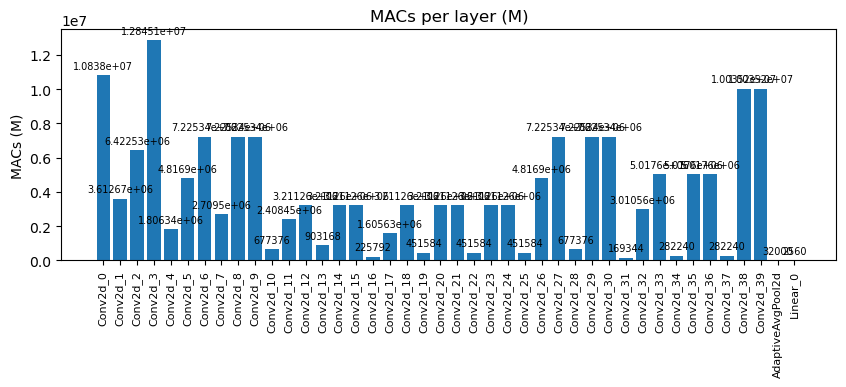

In [15]:
plot_results(macs_mbnet, res_type="macs")

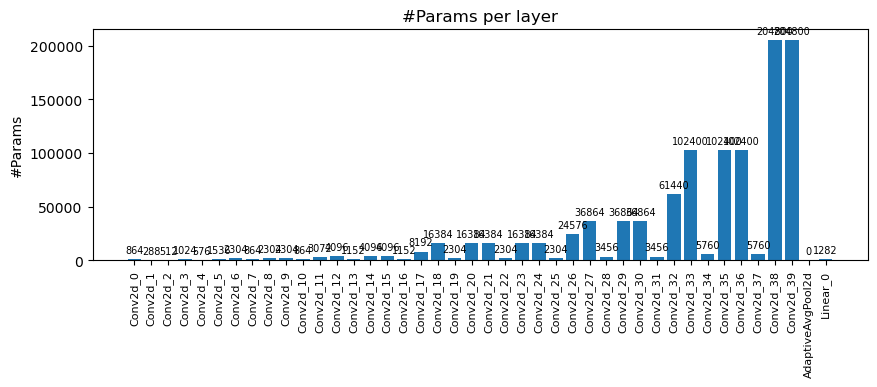

In [16]:
plot_results(params_mbnet, res_type="params")

In [17]:
print(summary(model_1M, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_1M                           [1, 2]                    --
├─Sequential: 1-1                        [1, 320, 7, 7]            --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4              [1, 16, 112, 112]         896
│    └─InvertedBlock: 2-3                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 24, 56, 56]           3,440
│    └─InvertedBlock: 2-4                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 24, 56, 56]           5,904
│    └─InvertedBlock: 2-5                [1, 32, 28, 28]           --
│    │ 

## MobileNetV2 Small

In [18]:
print(summary(model_small, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_SMALL                        [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           1,216
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           2,912
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │ 

In [19]:
# model_small

## MobileNetV2 Mini

In [20]:
print(summary(model_mini, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI                         [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   

In [21]:
# model_mini